<a href="https://colab.research.google.com/github/luiseduaardo/PneuModel/blob/main/eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
!git clone https://github.com/luiseduaardo/PneuModel

Cloning into 'PneuModel'...
remote: Enumerating objects: 5851, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 5851 (delta 0), reused 6 (delta 0), pack-reused 5841 (from 2)
Receiving objects: 100% (5851/5851), 1.16 GiB | 27.92 MiB/s, done.
Updating files: 100% (5859/5859), done.


In [51]:
%cd PneuModel

/content/PneuModel/PneuModel/PneuModel/PneuModel


In [52]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Inicialmente, vamos observar a **distribuição de classes** no nosso dataset de treinamento

In [53]:
path_treinamento = "./data/train/"
categorias = ["NORMAL", "PNEUMONIA"]

data = []
for category in categorias:
  path = path_treinamento + category
  for img in os.listdir(path):
    data.append([category])

df = pd.DataFrame(data, columns=["classe"])

contagem_classes = (df.groupby(by=["classe"], as_index=False)
  .agg(qtde_classe=("classe", "count")))

contagem_classes

,classe,qtde_classe
0,NORMAL,1349
1,PNEUMONIA,3883


Observando de maneira visual esse resultado, por meio de um histograma, temos o seguinte:

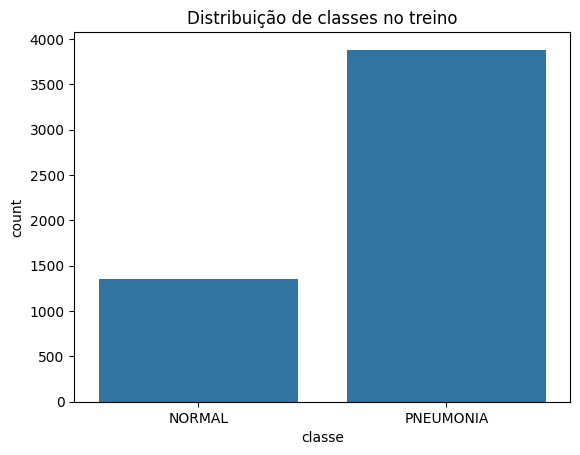

In [54]:
sns.countplot(x="classe", data=df)
plt.title("Distribuição de classes no treino")
plt.show()

---

A principal diferença visual entre um pulmão saudável e um pulmão com pneumonia reside na densidade das estruturas.

Um pulmão saudável aparece predominantemente escuro (radiotransparente), pois o ar permite a passagem dos raios-X.

Já um pulmão de uma pessoa acometida pela Pneumonia apresenta manchas esbranquiçadas ou áreas nubladas. Essa característica é comum tanto em casos de pneumonia bacteriana quanto viral.

Tomemos como exemplo algumas imagens selecionadas aleatoriamente de ambos os datasets:

In [55]:
import cv2

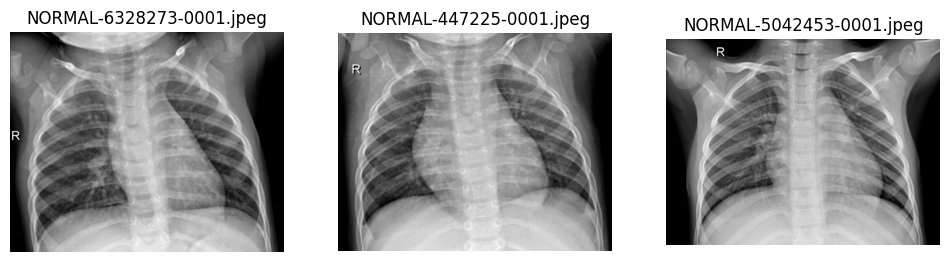

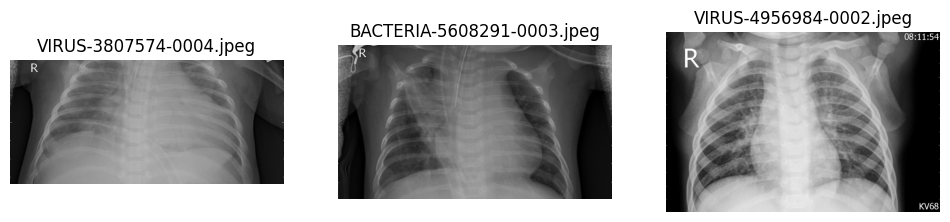

In [56]:
def plot_exemplo(category: str):
  path = path_treinamento + category
  imgs = os.listdir(path)[:3]

  plt.figure(figsize=(12,4))

  for i, img_name in enumerate(imgs):
    img_path = path + "/" + img_name
    img = cv2.imread(img_path)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(1, 3, i+1)
    plt.imshow(img)
    plt.title(img_name)
    plt.axis("off")

  plt.show()

plot_exemplo("NORMAL")
plot_exemplo("PNEUMONIA")

Fazendo uma análise estatística dos pixels das imagens do dataset de treinamento e comparando radiografias de pessoas saudáveis e acometidas, temos o seguinte:

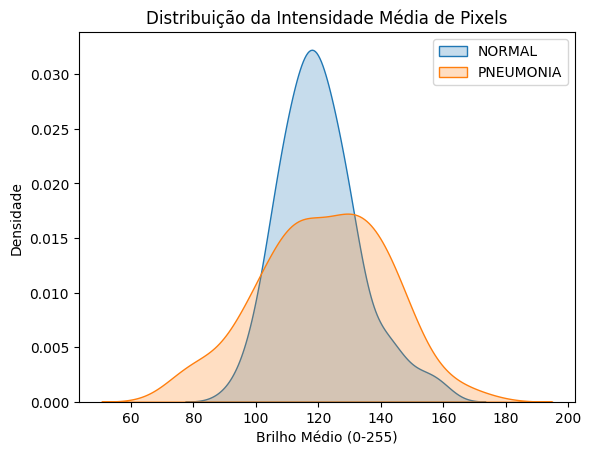

In [57]:
def pixels_stats(category: str):
  path = path_treinamento + category
  brightness_values = []

  for img_name in os.listdir(path)[:100]:
    img_path = path + "/" + img_name
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    brightness_values.append(np.mean(img))

  return brightness_values

normal_brightness = pixels_stats("NORMAL")
pneumonia_brightness = pixels_stats("PNEUMONIA")

sns.kdeplot(normal_brightness, label="NORMAL", fill=True)
sns.kdeplot(pneumonia_brightness, label="PNEUMONIA", fill=True)

plt.title('Distribuição da Intensidade Média de Pixels')
plt.xlabel('Brilho Médio (0-255)')
plt.ylabel('Densidade')
plt.legend()

A distribuição da intensidade de pixels revela que imagens com pneumonia apresentam uma variância maior e uma tendência a valores de brilho médio mais elevados, condizente com a presença de infiltrados inflamatórios que aumentam a radiodensidade no exame, indicada pela presença da luz branca.

Entretanto, essa estatística de distribuição de intensidade luminosa ainda não permite realizar a classificação, sendo, portanto, essencial a utilização de técnicas voltadas para a Visão Computacional para a extração de outras características relevantes que possam determinar a presença ou não de Pneumonia.

---

Para construírmos o nosso modelo, precisamos garantir que não existe uma variabilidade muito grande nas dimensões das imagens de entrada. Para isso, realizaremos uma análise através do gráfico de dispersão das dimensões:

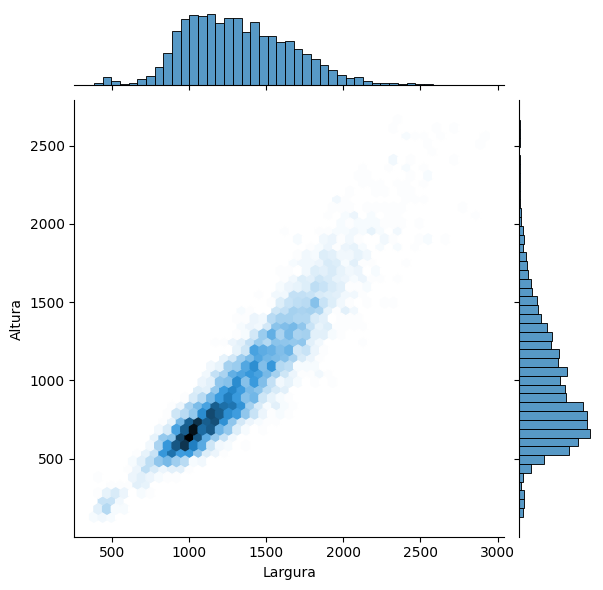

In [58]:
dims = []
for category in categorias:
    path = path_treinamento + category
    for img_name in os.listdir(path):
        img = cv2.imread(os.path.join(path, img_name))
        dims.append(img.shape[:2])

dims_df = pd.DataFrame(dims, columns=['Altura', 'Largura'])
sns.jointplot(x='Largura', y='Altura', data=dims_df, kind='hex')

O gráfico de dimensões mostra que nossas imagens originais são muito maiores do que o tamanho que o modelo consegue processar (224x224px). Como as imagens mantêm uma proporção constante, isto é, consistência no aspect ratio, o risco de deformar a anatomia do pulmão na redução das dimensões da imagem é baixo, mas precisamos ter cuidado para que essa redução não apague detalhes importantes.